# Gro Intelligence- Data Scientist Internship

Submitted By: Apoorva Gupta

Contact: gupta.apo@northeastern.edu
    (+1-857-316-8209)
    

**Background**
We have been given the monthly production quantity for a certain agricultural product in 10 different provinces of a country between January 2015 to December 2020. This Grople syrup comes from a fruit. It takes a few months for the fruits to grow on the trees which bear them. It also takes a few days to extract the syrup from the fruits after they have been harvested.

**Goal** To predict the production quantity for Grople syrup from Jan 2021 to Dec 2021

### 1.Data Preprocessing

Importing required libraries 

In [1]:
import warnings                                  # `do not disturbe` mode
warnings.filterwarnings('ignore')

import numpy as np                               # vectors and matrices
import pandas as pd                              # tables and data manipulations
import matplotlib.pyplot as plt                  # plots
import seaborn as sns                            # more plots

from dateutil.relativedelta import relativedelta # working with dates with style
from scipy.optimize import minimize              # for function minimization

import statsmodels.formula.api as smf            # statistics and econometrics
import statsmodels.tsa.api as smt
import statsmodels.api as sm
import scipy.stats as scs

from itertools import product                    # some useful functions
from tqdm import tqdm_notebook

%matplotlib inline

Importing all required datasets 

In [2]:
prec_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/Daily Precipitation.csv")
soil_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/Daily Soil Mositure.csv")
temp_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/Daily Temperature.csv")
ndvi_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/Eight Day NDVI.csv")
pred_qty_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/predicted_production_qty.csv")
prd_qty_df=pd.read_csv("C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/Production Quantity.csv")

In [3]:
prd_qty_df.head()

,start_date,end_date,prod,region_id
0,2015-01-01T00:00:00.000Z,2015-01-31T00:00:00.000Z,171725,93
1,2015-02-01T00:00:00.000Z,2015-02-28T00:00:00.000Z,188325,93
2,2015-03-01T00:00:00.000Z,2015-03-31T00:00:00.000Z,247856,93
3,2015-04-01T00:00:00.000Z,2015-04-30T00:00:00.000Z,282791,93
4,2015-05-01T00:00:00.000Z,2015-05-31T00:00:00.000Z,291057,93


### Feature Engineering

1. Since, the start_date is not in date format, we will convert it to date format and extract only useful columns
2. Since, the production data is at monthly level. We will aggreagte other varaibles at monthly level so that we can merge target variables and independent variables

Aggregating production quantity at monthly level

In [4]:
prd_qty_df['start_date'] = pd.to_datetime(prd_qty_df.start_date,format='%Y-%m-%d')  
prd_qty_df['Year']=prd_qty_df['start_date'].dt.year
prd_qty_df['Month']=prd_qty_df['start_date'].dt.month
prd_qty_df['YearMonth'] = prd_qty_df['start_date'].dt.to_period('M')
prd_qty_df_final=prd_qty_df[['YearMonth','Year','Month','region_id','prod']]
prd_qty_df_final.head()

,YearMonth,Year,Month,region_id,prod
0,2015-01,2015,1,93,171725
1,2015-02,2015,2,93,188325
2,2015-03,2015,3,93,247856
3,2015-04,2015,4,93,282791
4,2015-05,2015,5,93,291057


Aggregating precipitation data at monthly level

In [5]:
prec_df['start_date'] = pd.to_datetime(prec_df.start_date,format='%Y-%m-%d')  
prec_df['Year']=prec_df['start_date'].dt.year
prec_df['Month']=prec_df['start_date'].dt.month
prec_df['YearMonth'] = prec_df['start_date'].dt.to_period('M')
prec_df_final=prec_df.groupby(['YearMonth','Year','Month','region_id'])['precip'].mean().reset_index()
prec_df_final.head()


,YearMonth,Year,Month,region_id,precip
0,2014-01,2014,1,93,2.541758
1,2014-01,2014,1,94,0.903706
2,2014-01,2014,1,95,2.754678
3,2014-01,2014,1,97,1.486648
4,2014-01,2014,1,98,4.303181


Aggregating temperature data at monthly level

In [6]:
temp_df['start_date'] = pd.to_datetime(temp_df.start_date,format='%Y-%m-%d')  
temp_df['Year']=temp_df['start_date'].dt.year
temp_df['Month']=temp_df['start_date'].dt.month
temp_df['YearMonth'] = temp_df['start_date'].dt.to_period('M')
temp_df_final=temp_df.groupby(['YearMonth','Year','Month','region_id'])['temp'].mean().reset_index()
temp_df_final.head()

,YearMonth,Year,Month,region_id,temp
0,2014-01,2014,1,93,25.482158
1,2014-01,2014,1,94,25.857623
2,2014-01,2014,1,95,22.430714
3,2014-01,2014,1,97,25.554444
4,2014-01,2014,1,98,23.789993


Aggregating soil data at monthly level

In [7]:
soil_df['start_date'] = pd.to_datetime(soil_df.start_date,format='%Y-%m-%d')  
soil_df['Year']=soil_df['start_date'].dt.year
soil_df['Month']=soil_df['start_date'].dt.month
soil_df['YearMonth'] = soil_df['start_date'].dt.to_period('M')
soil_df_final=soil_df.groupby(['YearMonth','Year','Month','region_id'])['smos'].mean().reset_index()
soil_df_final.head()


,YearMonth,Year,Month,region_id,smos
0,2014-01,2014,1,93,0.287870
1,2014-01,2014,1,94,0.285901
2,2014-01,2014,1,95,0.268944
3,2014-01,2014,1,97,0.295487
4,2014-01,2014,1,98,0.207876


Aggregating ndvi data at monthly level

In [8]:
ndvi_df['start_date'] = pd.to_datetime(ndvi_df.start_date,format='%Y-%m-%d')  
ndvi_df['Year']=ndvi_df['start_date'].dt.year
ndvi_df['Month']=ndvi_df['start_date'].dt.month
ndvi_df['YearMonth'] = ndvi_df['start_date'].dt.to_period('M')
ndvi_df_final=ndvi_df.groupby(['YearMonth','Year','Month','region_id'])['ndvi'].mean().reset_index()
ndvi_df_final.head()

,YearMonth,Year,Month,region_id,ndvi
0,2013-12,2013,12,93,0.679106
1,2013-12,2013,12,94,0.749433
2,2013-12,2013,12,97,0.751093
3,2013-12,2013,12,99,0.784205
4,2013-12,2013,12,102,0.759486


To merege all variables in single dataset

In [9]:
new_Df1=prd_qty_df_final.merge(prec_df_final,on=["YearMonth","Year","Month","region_id"],how="outer")
new_Df2=new_Df1.merge(soil_df_final,on=["YearMonth","Year","Month","region_id"],how="outer")
new_Df3=new_Df2.merge(temp_df_final,on=["YearMonth","Year","Month","region_id"],how="outer")
new_Df4=new_Df3.merge(ndvi_df_final,on=["YearMonth","Year","Month","region_id"],how="outer")
new_Df4.head()

,YearMonth,Year,Month,region_id,prod,precip,smos,temp,ndvi
0,2015-01,2015,1,93,171725.0,4.394452,0.318552,25.003593,0.761228
1,2015-02,2015,2,93,188325.0,1.206137,0.291452,26.807568,0.758957
2,2015-03,2015,3,93,247856.0,3.454652,0.251969,26.954109,0.752754
3,2015-04,2015,4,93,282791.0,10.466472,0.248915,26.948865,0.785057
4,2015-05,2015,5,93,291057.0,9.007986,0.280602,25.405121,0.805262


#### Missing value

In [10]:
new_Df4.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 997 entries, 0 to 996
Data columns (total 9 columns):
 #   Column     Non-Null Count  Dtype    
---  ------     --------------  -----    
 0   YearMonth  997 non-null    period[M]
 1   Year       997 non-null    int64    
 2   Month      997 non-null    int64    
 3   region_id  997 non-null    int64    
 4   prod       720 non-null    float64  
 5   precip     990 non-null    float64  
 6   smos       990 non-null    float64  
 7   temp       990 non-null    float64  
 8   ndvi       993 non-null    float64  
dtypes: float64(5), int64(3), period[M](1)
memory usage: 77.9 KB


In [11]:
#missing data
total = new_Df4.isnull().sum().sort_values(ascending=False)
percent = (new_Df4.isnull().sum()/new_Df4.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
prod,277,0.277834
precip,7,0.007021
smos,7,0.007021
temp,7,0.007021
ndvi,4,0.004012
YearMonth,0,0.000000
Year,0,0.000000
Month,0,0.000000
region_id,0,0.000000


Since, the production data is only available for January 2015 to Dec 2020 and other variable are available for longer periods. We can remove the data for which production data is not available 

In [12]:
new_Df4.loc[new_Df4['prod'].isnull()]

,YearMonth,Year,Month,region_id,prod,precip,smos,temp,ndvi
720,2014-01,2014,1,93,NaN,2.541758,0.287870,25.482158,0.740574
721,2014-01,2014,1,94,NaN,0.903706,0.285901,25.857623,0.768065
722,2014-01,2014,1,95,NaN,2.754678,0.268944,22.430714,0.733848
723,2014-01,2014,1,97,NaN,1.486648,0.295487,25.554444,0.758562
724,2014-01,2014,1,98,NaN,4.303181,0.207876,23.789993,0.793146
...,...,...,...,...,...,...,...,...,...
992,2013-12,2013,12,97,NaN,NaN,NaN,NaN,0.751093
993,2013-12,2013,12,99,NaN,NaN,NaN,NaN,0.784205
994,2013-12,2013,12,102,NaN,NaN,NaN,NaN,0.759486
995,2013-12,2013,12,103,NaN,NaN,NaN,NaN,0.747496


Dropping missing values in the dataset

In [13]:
new_Df5=new_Df4.dropna()

In [14]:
#missing data
total = new_Df5.isnull().sum().sort_values(ascending=False)
percent = (new_Df5.isnull().sum()/new_Df5.isnull().count()).sort_values(ascending=False)
missing_data = pd.concat([total, percent], axis=1, keys=['Total', 'Percent'])
missing_data.head(25)

,Total,Percent
YearMonth,0,0.0
Year,0,0.0
Month,0,0.0
region_id,0,0.0
prod,0,0.0
precip,0,0.0
smos,0,0.0
temp,0,0.0
ndvi,0,0.0


There are no missing values now in the dataset, we can proceed further

#### Outlier treatment 

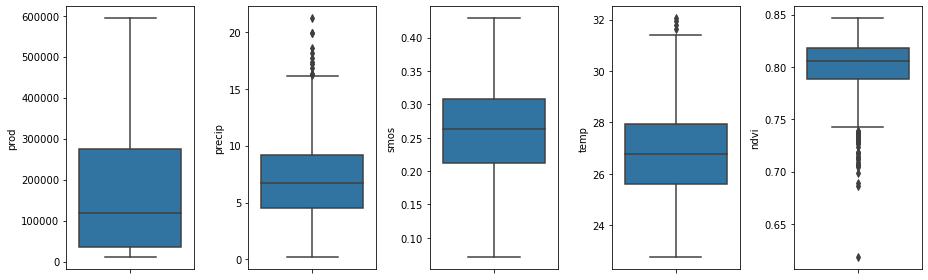

In [15]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,5,1)
sns.boxplot(y = new_Df5['prod'])
plt.subplot(1,5,2)
sns.boxplot(y = new_Df5['precip'])
plt.subplot(1,5,3)
sns.boxplot(y = new_Df5['smos'])
plt.subplot(1,5,4)
sns.boxplot(y = new_Df5['temp'])
plt.subplot(1,5,5)
sns.boxplot(y = new_Df5['ndvi'])

plt.tight_layout()
plt.show()

In ndvi, there is one extreme outlier

In [16]:
new_Df5.loc[new_Df5['ndvi']<0.65]

,YearMonth,Year,Month,region_id,prod,precip,smos,temp,ndvi
8,2015-09,2015,9,93,299337.0,4.057924,0.273908,28.357386,0.617915


Lets check the monthly trend for region_id=93 across all years

<AxesSubplot:xlabel='Month'>

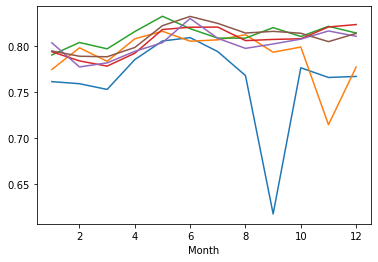

In [17]:
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2015)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2016)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2017)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2018)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2019)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2020)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2021)].groupby('Month')['ndvi'].mean().plot()
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Year']==2022)].groupby('Month')['ndvi'].mean().plot()

There is extreme outlier for year 2015 in month of 9. Lets replace its value with average value for other years 

In [18]:
val=new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Month']==9)]['ndvi'].mean()
val
new_Df5.loc[((new_Df5['region_id']==93) & (new_Df5['Month']==9) & (new_Df5['Year']==2015)),'ndvi']=val
new_Df5.loc[(new_Df5['region_id']==93) & (new_Df5['Month']==9) & (new_Df5['Year']==2015)]

,YearMonth,Year,Month,region_id,prod,precip,smos,temp,ndvi
8,2015-09,2015,9,93,299337.0,4.057924,0.273908,28.357386,0.775885


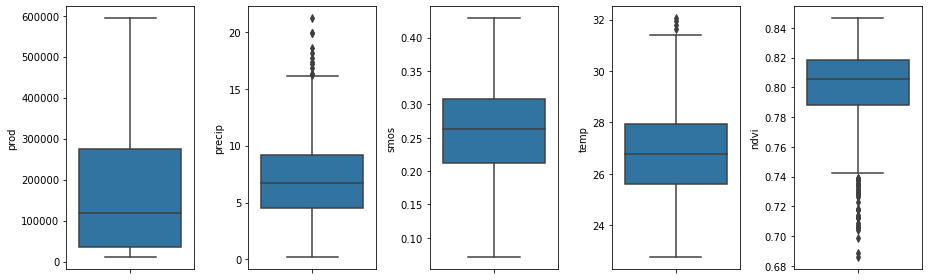

In [19]:
#Checking distribution - Boxplot
plt.figure(figsize=(13, 4))
plt.subplot(1,5,1)
sns.boxplot(y = new_Df5['prod'])
plt.subplot(1,5,2)
sns.boxplot(y = new_Df5['precip'])
plt.subplot(1,5,3)
sns.boxplot(y = new_Df5['smos'])
plt.subplot(1,5,4)
sns.boxplot(y = new_Df5['temp'])
plt.subplot(1,5,5)
sns.boxplot(y = new_Df5['ndvi'])

plt.tight_layout()
plt.show()

We have treated the outliers, now the values seems to be in range

### Exploratory data analysis

#### Check the correlation

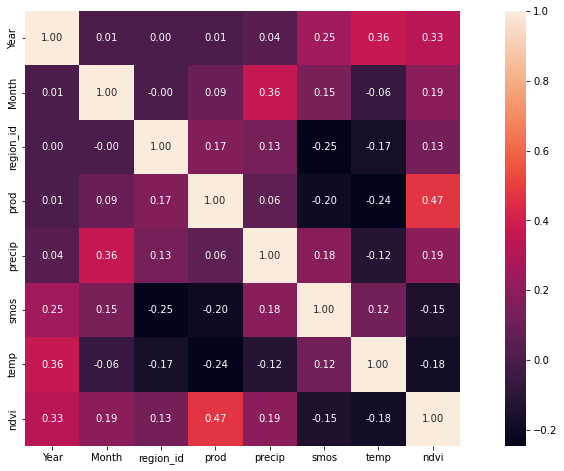

In [20]:
#saleprice correlation matrix
k = 15 #number of variables for heatmap
plt.figure(figsize=(16,8))
corrmat = new_Df5.corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f', annot_kws={'size': 10})
plt.show()

<BarContainer object of 10 artists>

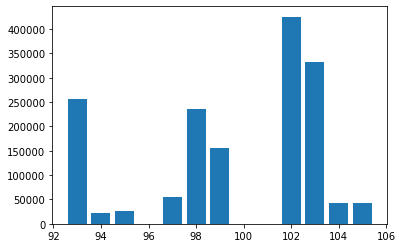

In [21]:
temp=new_Df5.groupby(['region_id'])['prod'].mean().reset_index()
plt.bar(temp['region_id'],temp['prod'])

There is huge variation in the production value for each regions

<BarContainer object of 10 artists>

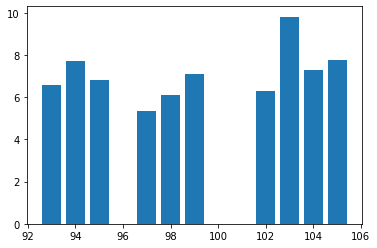

In [22]:
temp=new_Df5.groupby(['region_id'])['precip'].mean().reset_index()
plt.bar(temp['region_id'],temp['precip'])

There is variation in the precipitation value for each regions

<BarContainer object of 10 artists>

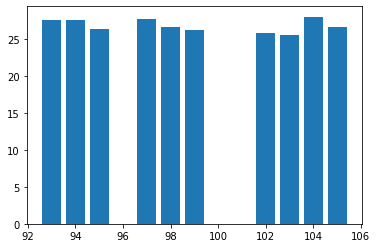

In [23]:
temp=new_Df5.groupby(['region_id'])['temp'].mean().reset_index()
plt.bar(temp['region_id'],temp['temp'])

<BarContainer object of 10 artists>

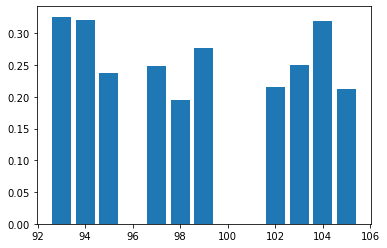

In [24]:
temp=new_Df5.groupby(['region_id'])['smos'].mean().reset_index()
plt.bar(temp['region_id'],temp['smos'])

<BarContainer object of 10 artists>

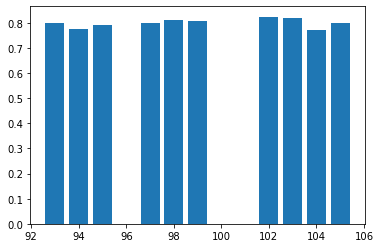

In [25]:
temp=new_Df5.groupby(['region_id'])['ndvi'].mean().reset_index()
plt.bar(temp['region_id'],temp['ndvi'])

Now, looking over the trend of prodcution and precipitation simultaneously

<AxesSubplot:xlabel='Month'>

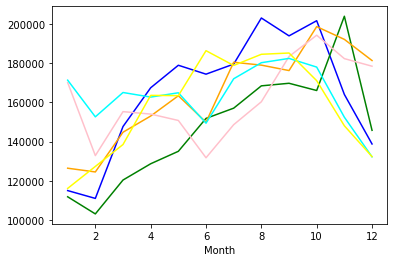

In [26]:
new_Df5.loc[new_Df5['Year']==2015].groupby(['Month'])['prod'].mean().plot(color='blue')
new_Df5.loc[new_Df5['Year']==2016].groupby(['Month'])['prod'].mean().plot(color='green')
new_Df5.loc[new_Df5['Year']==2017].groupby(['Month'])['prod'].mean().plot(color='orange')
new_Df5.loc[new_Df5['Year']==2018].groupby(['Month'])['prod'].mean().plot(color='pink')
new_Df5.loc[new_Df5['Year']==2019].groupby(['Month'])['prod'].mean().plot(color='cyan')
new_Df5.loc[new_Df5['Year']==2020].groupby(['Month'])['prod'].mean().plot(color='yellow')

Production is almost follwoing the same trend for years from 2015 to 2019

<AxesSubplot:xlabel='Month'>

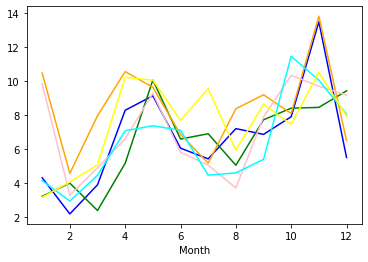

In [27]:
new_Df5.loc[new_Df5['Year']==2015].groupby(['Month'])['precip'].mean().plot(color='blue')
new_Df5.loc[new_Df5['Year']==2016].groupby(['Month'])['precip'].mean().plot(color='green')
new_Df5.loc[new_Df5['Year']==2017].groupby(['Month'])['precip'].mean().plot(color='orange')
new_Df5.loc[new_Df5['Year']==2018].groupby(['Month'])['precip'].mean().plot(color='pink')
new_Df5.loc[new_Df5['Year']==2019].groupby(['Month'])['precip'].mean().plot(color='cyan')
new_Df5.loc[new_Df5['Year']==2020].groupby(['Month'])['precip'].mean().plot(color='yellow')

<AxesSubplot:xlabel='Month'>

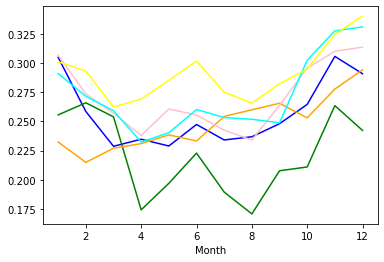

In [28]:
new_Df5.loc[new_Df5['Year']==2015].groupby(['Month'])['smos'].mean().plot(color='blue')
new_Df5.loc[new_Df5['Year']==2016].groupby(['Month'])['smos'].mean().plot(color='green')
new_Df5.loc[new_Df5['Year']==2017].groupby(['Month'])['smos'].mean().plot(color='orange')
new_Df5.loc[new_Df5['Year']==2018].groupby(['Month'])['smos'].mean().plot(color='pink')
new_Df5.loc[new_Df5['Year']==2019].groupby(['Month'])['smos'].mean().plot(color='cyan')
new_Df5.loc[new_Df5['Year']==2020].groupby(['Month'])['smos'].mean().plot(color='yellow')

<AxesSubplot:xlabel='Month'>

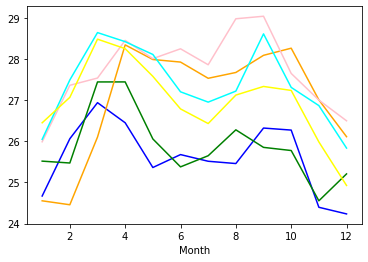

In [29]:
new_Df5.loc[new_Df5['Year']==2015].groupby(['Month'])['temp'].mean().plot(color='blue')
new_Df5.loc[new_Df5['Year']==2016].groupby(['Month'])['temp'].mean().plot(color='green')
new_Df5.loc[new_Df5['Year']==2017].groupby(['Month'])['temp'].mean().plot(color='orange')
new_Df5.loc[new_Df5['Year']==2018].groupby(['Month'])['temp'].mean().plot(color='pink')
new_Df5.loc[new_Df5['Year']==2019].groupby(['Month'])['temp'].mean().plot(color='cyan')
new_Df5.loc[new_Df5['Year']==2020].groupby(['Month'])['temp'].mean().plot(color='yellow')

<AxesSubplot:xlabel='Month'>

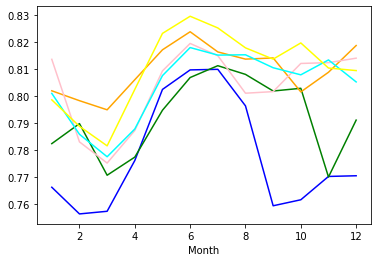

In [30]:
new_Df5.loc[new_Df5['Year']==2015].groupby(['Month'])['ndvi'].mean().plot(color='blue')
new_Df5.loc[new_Df5['Year']==2016].groupby(['Month'])['ndvi'].mean().plot(color='green')
new_Df5.loc[new_Df5['Year']==2017].groupby(['Month'])['ndvi'].mean().plot(color='orange')
new_Df5.loc[new_Df5['Year']==2018].groupby(['Month'])['ndvi'].mean().plot(color='pink')
new_Df5.loc[new_Df5['Year']==2019].groupby(['Month'])['ndvi'].mean().plot(color='cyan')
new_Df5.loc[new_Df5['Year']==2020].groupby(['Month'])['ndvi'].mean().plot(color='yellow')

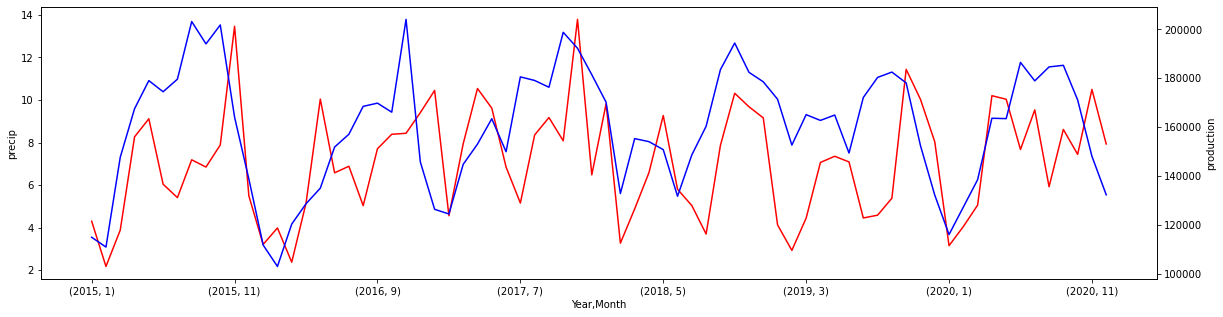

In [31]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, ax1 = plt.subplots() 

temp1=new_Df5.groupby(['Year','Month'])['precip'].mean()
temp4=new_Df5.groupby(['Year','Month'])['prod'].mean()

ax1.set_xlabel('X-axis') 
ax1.set_ylabel('precip') 
temp1.plot(color='red')
  
# Adding Twin Axes
ax2 = ax1.twinx() 
temp4.plot(color='blue')

# Add label
plt.ylabel('production') 

# Show plot
plt.show()

Till (2015, 9), both trend follows the same trend. After(2015, 10) there is slight differnence(~same month) in the trend patterns.After (2015,11), it started follwong the same trend 

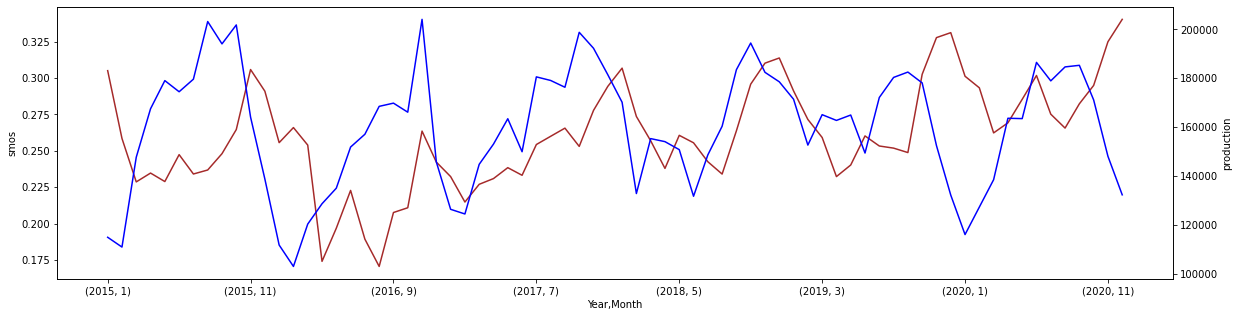

In [32]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, ax1 = plt.subplots() 
temp1=new_Df5.groupby(['Year','Month'])['smos'].mean()
temp4=new_Df5.groupby(['Year','Month'])['prod'].mean()

ax1.set_xlabel('X-axis') 
ax1.set_ylabel('smos') 
temp1.plot(color='brown')
  
# Adding Twin Axes

ax2 = ax1.twinx() 
temp4.plot(color='blue')
# Add label

plt.ylabel('production') 

# Show plot

plt.show()

there is slight differnence(2 months) in the trend patterns 

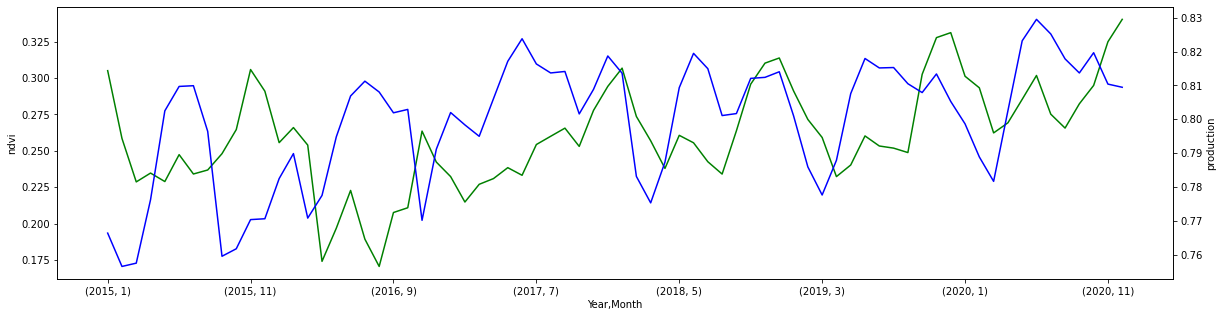

In [33]:
plt.rcParams["figure.figsize"] = (20, 5)
fig, ax1 = plt.subplots() 
temp1=new_Df5.groupby(['Year','Month'])['smos'].mean()
temp4=new_Df5.groupby(['Year','Month'])['ndvi'].mean()

ax1.set_xlabel('X-axis') 
ax1.set_ylabel('ndvi') 
temp1.plot(color='green')
  
# Adding Twin Axes

ax2 = ax1.twinx() 
temp4.plot(color='blue')
# Add label

plt.ylabel('production') 

# Show plot

plt.show()

there is slight differnence(~3 months) in the trend patterns.After (2015,11), it started follwong the same trend 

Store all region values

In [34]:
region=new_Df5['region_id'].unique()
region

array([ 93,  94,  95,  97,  98,  99, 102, 103, 104, 105], dtype=int64)

### Feature generation

In [35]:
lag_features = ["precip", "smos", "temp", "ndvi"]
window1 = 2
window2 = 3
window3 = 4
final_df = pd.DataFrame()

for i in range(0,10):
    df=new_Df5.loc[(new_Df5['region_id']==region[i])]
    df=pd.DataFrame(df)
    
    df_rolled_2m = df[lag_features].rolling(window=window1, min_periods=0)
    df_rolled_3m = df[lag_features].rolling(window=window2, min_periods=0)
    df_rolled_4m = df[lag_features].rolling(window=window3, min_periods=0)
    
    df_mean_2m = df_rolled_2m.mean().shift(1).astype(np.float32)
    df_mean_3m = df_rolled_3m.mean().shift(1).astype(np.float32)
    df_mean_4m = df_rolled_4m.mean().shift(1).astype(np.float32)
    
    df_std_2m = df_rolled_2m.std().shift(1).astype(np.float32)
    df_std_3m = df_rolled_3m.std().shift(1).astype(np.float32)
    df_std_4m = df_rolled_4m.std().shift(1).astype(np.float32)
    
    for feature in lag_features:
        #var=feature+"_mean_lag"+str(window1)
        df[f"{feature}_mean_lag{window1}"] = df_mean_2m[feature]
        df[f"{feature}_mean_lag{window2}"] = df_mean_3m[feature]
        df[f"{feature}_mean_lag{window3}"] = df_mean_4m[feature]
        
        df[f"{feature}_std_lag{window1}"] = df_std_2m[feature]
        df[f"{feature}_std_lag{window2}"] = df_std_3m[feature]
        df[f"{feature}_std_lag{window3}"] = df_std_4m[feature]
       
    final_df=final_df.append(df)
    

In [36]:
final_df.loc[(final_df['Year'].isin([2015])) & (final_df["region_id"].isin([93])) ]

,YearMonth,Year,Month,region_id,prod,precip,smos,temp,ndvi,precip_mean_lag2,...,temp_mean_lag4,temp_std_lag2,temp_std_lag3,temp_std_lag4,ndvi_mean_lag2,ndvi_mean_lag3,ndvi_mean_lag4,ndvi_std_lag2,ndvi_std_lag3,ndvi_std_lag4
0,2015-01,2015,1,93,171725.0,4.394452,0.318552,25.003593,0.761228,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
1,2015-02,2015,2,93,188325.0,1.206137,0.291452,26.807568,0.758957,4.394452,...,25.003593,NaN,NaN,NaN,0.761228,0.761228,0.761228,NaN,NaN,NaN
2,2015-03,2015,3,93,247856.0,3.454652,0.251969,26.954109,0.752754,2.800295,...,25.905581,1.275603,1.275603,1.275603,0.760093,0.760093,0.760093,0.001606,0.001606,0.001606
3,2015-04,2015,4,93,282791.0,10.466472,0.248915,26.948865,0.785057,2.330395,...,26.255091,0.103620,1.086302,1.086302,0.755856,0.757647,0.757647,0.004386,0.004386,0.004386
4,2015-05,2015,5,93,291057.0,9.007986,0.280602,25.405121,0.805262,6.960562,...,26.428534,0.003708,0.083133,0.952382,0.768906,0.765590,0.764499,0.022841,0.017142,0.014165
5,2015-06,2015,6,93,287502.0,4.858355,0.304410,26.195865,0.808884,9.737229,...,26.528915,1.091592,0.892799,0.752265,0.795159,0.781024,0.775508,0.014287,0.026485,0.024277
6,2015-07,2015,7,93,288086.0,5.410755,0.306066,26.404261,0.793719,6.933171,...,26.375990,0.559141,0.771949,0.738792,0.807073,0.799734,0.787989,0.002561,0.012840,0.025723
7,2015-08,2015,8,93,313321.0,5.825761,0.297529,25.533003,0.767774,5.134555,...,26.238527,0.147358,0.527097,0.639905,0.801302,0.802622,0.798231,0.010724,0.007920,0.010906
8,2015-09,2015,9,93,299337.0,4.057924,0.273908,28.357386,0.775885,5.618258,...,25.884562,0.616072,0.454955,0.490052,0.780746,0.790126,0.793910,0.018346,0.020790,0.018585
9,2015-10,2015,10,93,300383.0,5.668797,0.280682,28.483907,0.776229,4.941842,...,26.622629,1.997140,1.446313,1.214699,0.771830,0.779126,0.786566,0.005736,0.013273,0.018407


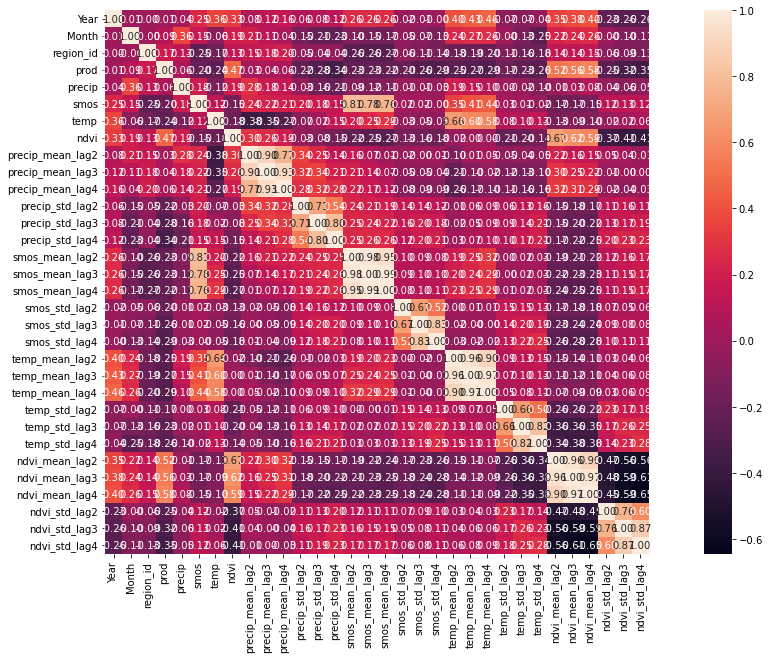

In [37]:
#saleprice correlation matrix

plt.figure(figsize=(20,10))
corrmat = final_df.corr()
hm = sns.heatmap(corrmat, cbar=True, annot=True, square=True, fmt='.2f')
plt.show()

Check the stationary of data
Null Hypothesis: Data is non stationary

In [38]:
def dicky_fuller_test(x):
    result = adfuller(x)
    print('ADF Statistic: %f' % result[0])
    print('p-value: %f' % result[1])
    print('Critical Values:')
    for key, value in result[4].items():
        print('\t%s: %.3f' % (key, value))
    if result[1]>0.05:
        print("Fail to reject the null hypothesis (H0), the data is non-stationary")
    else:
        print("Reject the null hypothesis (H0), the data is stationary.")

In [39]:
from statsmodels.tsa.stattools import adfuller
dicky_fuller_test(final_df['prod'])

ADF Statistic: -2.035965
p-value: 0.271030
Critical Values:
	1%: -3.440
	5%: -2.866
	10%: -2.569
Fail to reject the null hypothesis (H0), the data is non-stationary


#### Sesonal decompose

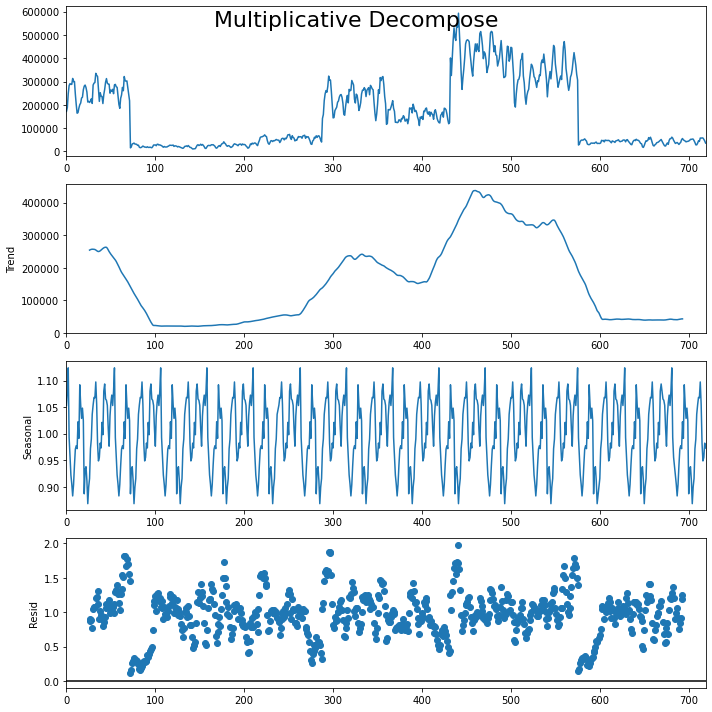

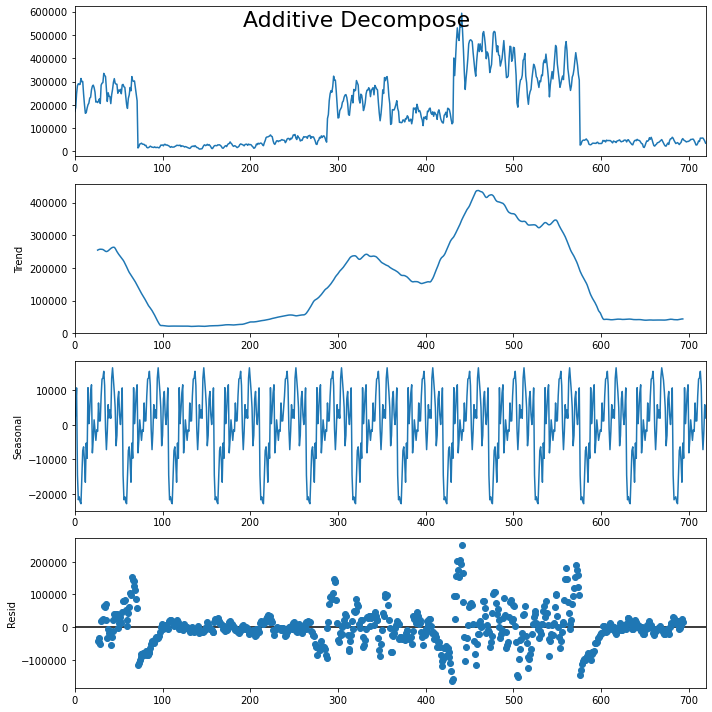

In [40]:
from statsmodels.tsa.seasonal import seasonal_decompose
from dateutil.parser import parse

plt.rcParams.update({'figure.figsize': (10,10)})

y = final_df['prod'].to_frame()


# Multiplicative Decomposition 
result_mul = seasonal_decompose(y, model='multiplicative',period = 52)

# Additive Decomposition
result_add = seasonal_decompose(y, model='additive',period = 52)

# Plot
plt.rcParams.update({'figure.figsize': (10,10)})
result_mul.plot().suptitle('Multiplicative Decompose', fontsize=22)
result_add.plot().suptitle('Additive Decompose', fontsize=22)
plt.show()

#### Plotting ACF and PACF

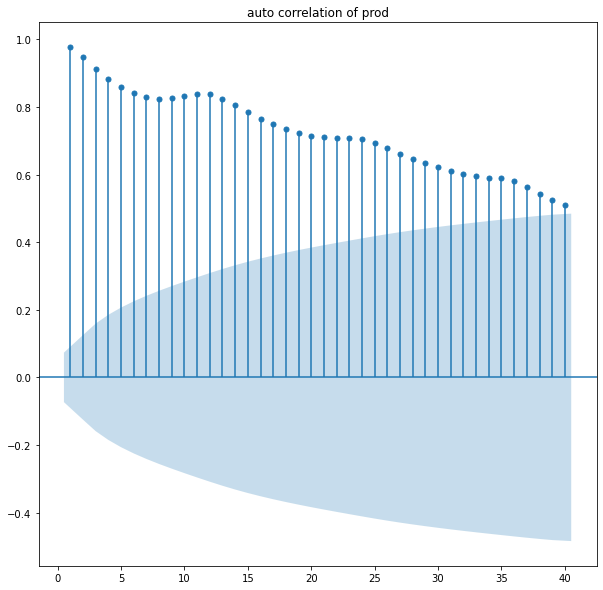

In [41]:
sm.graphics.tsa.plot_acf(final_df['prod'].iloc[1:], lags=40,title='auto correlation of prod',zero=False)
plt.show()

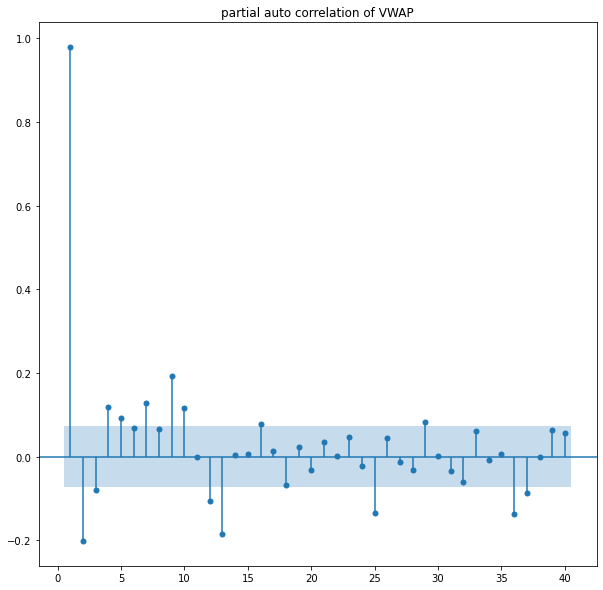

In [42]:
sm.graphics.tsa.plot_pacf(final_df['prod'].iloc[1:], lags=40,title='partial auto correlation of VWAP',zero=False)
plt.show()

### 1. Auto ARIMA Model

In [43]:

exogenous_features =[ 'precip', 'smos',
       'temp', 'ndvi', 'precip_mean_lag2', 'precip_mean_lag3',
       'precip_mean_lag4', 'precip_std_lag2', 'precip_std_lag3',
       'precip_std_lag4', 'smos_mean_lag2', 'smos_mean_lag3', 'smos_mean_lag4',
       'smos_std_lag2', 'smos_std_lag3', 'smos_std_lag4', 'temp_mean_lag2',
       'temp_mean_lag3', 'temp_mean_lag4', 'temp_std_lag2', 'temp_std_lag3',
       'temp_std_lag4', 'ndvi_mean_lag2', 'ndvi_mean_lag3', 'ndvi_mean_lag4',
       'ndvi_std_lag2', 'ndvi_std_lag3', 'ndvi_std_lag4']

In [44]:
final_df.fillna(final_df.mean(), inplace=True)

In [45]:
import pyramid
from pmdarima import auto_arima

train_final_df=pd.DataFrame()
valid_final_df=pd.DataFrame()

for i in range(0,10):
    df=final_df.loc[(final_df['region_id']==region[i])]
    df=pd.DataFrame(df)
    
    df_train = df[df.Year < 2018]
    df_valid = df[df.Year >= 2018]

    model = auto_arima(df_train['prod'], exogenous=df_train[exogenous_features], trace=True, error_action="ignore", suppress_warnings=True)
    model.fit(df_train['prod'], exogenous=df_train[exogenous_features])

    forecast = model.predict(n_periods=len(df_valid), exogenous=df_valid[exogenous_features])
    df_valid["Forecast_ARIMAX"] = forecast
    
    train_final_df=train_final_df.append(df_train)
    valid_final_df=valid_final_df.append(df_valid)
    

Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=875.391, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=880.931, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=877.381, Time=0.42 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=967.398, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=881.914, Time=0.38 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.686 seconds
Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=718.682, Time=1.04 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=720.006, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=721.864, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=721.888, Time=0.19 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=718.007, Time=0.19 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=723.841, Time=0.29 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time

C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=721.300, Time=0.72 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=721.519, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=723.385, Time=0.58 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=721.282, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=719.519, Time=0.26 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.66 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 2.860 seconds


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.83 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=738.728, Time=0.05 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=740.672, Time=0.15 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=740.766, Time=0.17 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=736.728, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=742.473, Time=0.49 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0]          
Total fit time: 1.851 seconds
Performing stepwise search to minimize aic


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.55 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=877.960, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=878.112, Time=0.25 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=878.460, Time=0.08 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=969.966, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=879.421, Time=0.34 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.274 seconds
Performing stepwise search to minimize aic


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=832.474, Time=0.48 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=837.345, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=836.071, Time=0.19 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=836.766, Time=0.23 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=835.345, Time=0.17 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=830.999, Time=0.76 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=831.581, Time=0.39 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=838.038, Time=0.24 sec
 ARIMA(1,0,3)(0,0,0)[0] intercept   : AIC=829.201, Time=0.70 sec
 ARIMA(0,0,3)(0,0,0)[0] intercept   : AIC=831.478, Time=0.45 sec
 ARIMA(2,0,3)(0,0,0)[0] intercept   : AIC=831.717, Time=0.76 sec
 ARIMA(1,0,4)(0,0,0)[0] intercept   : AIC=831.501, Time=0.79 sec
 ARIMA(0,0,4)(0,0,0)[0] intercept   : AIC=inf, Time=0.42 sec
 ARIMA(2,0,4)(0,0,0)[0] intercept   : AIC=833.201, Time=0.90 sec
 ARIMA(1,0,3)(0,0,0)[0]             : AIC=827.757, Time=0.68 sec
 ARIMA(0,0,3)(0,0,0)[0]      

C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.75 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=892.224, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=893.774, Time=0.08 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=893.671, Time=0.22 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=984.230, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.61 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.720 seconds
Performing stepwise search to minimize aic


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=884.652, Time=0.73 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=878.112, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=880.149, Time=0.23 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=880.526, Time=0.26 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=970.119, Time=0.03 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=880.425, Time=0.34 sec

Best model:  ARIMA(0,0,0)(0,0,0)[0] intercept
Total fit time: 1.623 seconds
Performing stepwise search to minimize aic


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.71 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=711.250, Time=0.03 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=713.011, Time=0.56 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.63 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=709.250, Time=0.17 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=704.195, Time=0.73 sec
 ARIMA(2,0,1)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.70 sec
 ARIMA(2,0,0)(0,0,0)[0] intercept   : AIC=706.740, Time=0.38 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=inf, Time=0.60 sec

Best model:  ARIMA(1,0,1)(0,0,0)[0] intercept
Total fit time: 5.984 seconds


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


Performing stepwise search to minimize aic
 ARIMA(2,0,2)(0,0,0)[0] intercept   : AIC=inf, Time=0.77 sec
 ARIMA(0,0,0)(0,0,0)[0] intercept   : AIC=708.746, Time=0.04 sec
 ARIMA(1,0,0)(0,0,0)[0] intercept   : AIC=707.037, Time=0.16 sec
 ARIMA(0,0,1)(0,0,0)[0] intercept   : AIC=706.532, Time=0.60 sec
 ARIMA(0,0,0)(0,0,0)[0]             : AIC=706.747, Time=0.16 sec
 ARIMA(1,0,1)(0,0,0)[0] intercept   : AIC=708.663, Time=0.40 sec
 ARIMA(0,0,2)(0,0,0)[0] intercept   : AIC=708.551, Time=0.58 sec
 ARIMA(1,0,2)(0,0,0)[0] intercept   : AIC=710.632, Time=0.64 sec
 ARIMA(0,0,1)(0,0,0)[0]             : AIC=704.747, Time=0.07 sec
 ARIMA(1,0,1)(0,0,0)[0]             : AIC=706.734, Time=0.12 sec
 ARIMA(0,0,2)(0,0,0)[0]             : AIC=706.551, Time=0.55 sec
 ARIMA(1,0,0)(0,0,0)[0]             : AIC=705.038, Time=0.14 sec
 ARIMA(1,0,2)(0,0,0)[0]             : AIC=708.382, Time=0.68 sec

Best model:  ARIMA(0,0,1)(0,0,0)[0]          
Total fit time: 4.919 seconds


C:\Users\apoor\anaconda3\lib\site-packages\statsmodels\tsa\base\tsa_model.py:376: ValueWarning: No supported index is available. Prediction results will be given with an integer index beginning at `start`.
  warnings.warn('No supported index is available.'


In [46]:
# Accuracy metrics
def forecast_accuracy(forecast, actual):
    mape = np.mean(np.abs(forecast - actual)/np.abs(actual))  # MAPE
    me = np.mean(forecast - actual)             # ME
    mae = np.mean(np.abs(forecast - actual))    # MAE
    mpe = np.mean((forecast - actual)/actual)   # MPE
    rmse = np.mean((forecast - actual)**2)**.5  # RMSE
    corr = np.corrcoef(forecast, actual)[0,1]   # corr
    mins = np.amin(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    maxs = np.amax(np.hstack([forecast[:,None], 
                              actual[:,None]]), axis=1)
    minmax = 1 - np.mean(mins/maxs)             # minmax
    
    return({'mape':mape, 'me':me, 'mae': mae, 
            'mpe': mpe, 'rmse':rmse,  
            'corr':corr, 'minmax':minmax})

forecast_accuracy(valid_final_df['Forecast_ARIMAX'], valid_final_df['prod'])

{'mape': 0.3122424005055689,
 'me': 7372.681817216351,
 'mae': 40349.18756468055,
 'mpe': -0.03335154604329576,
 'rmse': 65083.90120215908,
 'corr': 0.9313754503661805,
 'minmax': 0.26695582851475386}

**MAPE of Auto Arima model**
MAPE of Auto Arima model is 0.31

**Accuracy of Auto Arima model**
Mape value is 31%. Hence, Accuracy of Auto Arima model is 69%

In [47]:
from sklearn.metrics import r2_score
r2 = r2_score(valid_final_df['prod'], valid_final_df['Forecast_ARIMAX'])
print(r2)

0.7889061921599085


**R2 score of Auto Arima model**
R2 score of Auto Arima model is 0.78

#### Arima model forecast graph

<AxesSubplot:xlabel='YearMonth'>

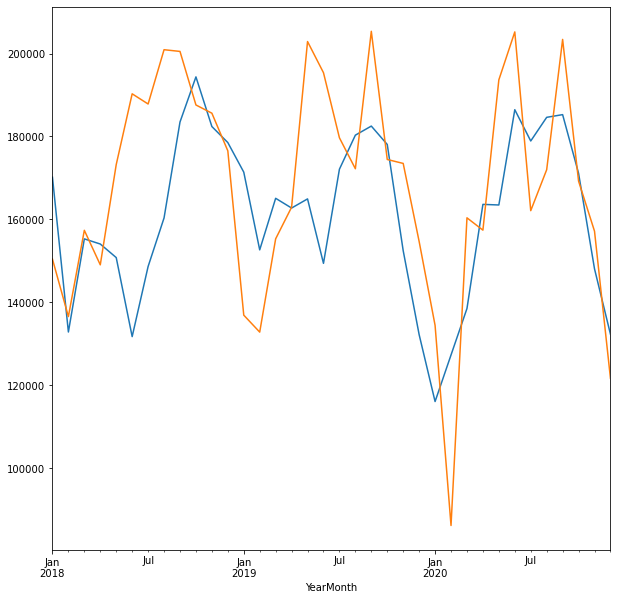

In [48]:
valid_final_df.groupby(["YearMonth"])['prod'].mean().plot()
valid_final_df.groupby(["YearMonth"])['Forecast_ARIMAX'].mean().plot()


In [49]:
from sklearn import ensemble
from sklearn.utils import shuffle
from sklearn.metrics import mean_squared_error, r2_score
import itertools

### 2. Gradient Boosting Model

In [50]:
from sklearn.model_selection import train_test_split
from matplotlib import dates
from sklearn.preprocessing import StandardScaler

X=final_df.drop(columns='prod')
y=final_df['prod'].values

X_train, X_test, y_train, y_test = train_test_split(X,y,test_size=0.4, random_state=101)
X_train['YearMonth'] = X_train['YearMonth'].apply(dates.date2num)
X_test['YearMonth'] = X_test['YearMonth'].apply(dates.date2num)

y_train= y_train.reshape(-1,1)
y_test= y_test.reshape(-1,1)

#print(y_test)

sc_X = StandardScaler()
sc_y = StandardScaler()
X_train = sc_X.fit_transform(X_train)
X_test = sc_X.fit_transform(X_test)

params = {'n_estimators': 700, 'max_depth': 3, 'min_samples_split': 5,
      'learning_rate': 0.08, 'loss': 'ls'}
clf = ensemble.GradientBoostingRegressor(**params)

clf.fit(X_train, y_train)

clf_pred=clf.predict(X_test)
clf_pred= clf_pred.reshape(-1,1)



In [51]:
accuracy_lr = clf.score(X_test, y_test)
print(accuracy_lr*100)

91.79958194719148


**Accuracy of Gradient Boosting model**
Accuracy of Gradient Boosting model is 92%

In [52]:
from sklearn.metrics import r2_score
r2 = r2_score(y_test, clf_pred)
print(r2)

0.9179958194719149


**R2 score of Gradient Boosting model**
R2 score of Gradient Boosting model is 0.91

In [53]:
import sklearn.metrics as metrics
print('MAE:', metrics.mean_absolute_error(y_test, clf_pred))
print('MSE:', metrics.mean_squared_error(y_test, clf_pred))
print('RMSE:', np.sqrt(metrics.mean_squared_error(y_test, clf_pred)))
print('MAPE:', np.mean(np.abs(clf_pred - y_test)/np.abs(y_test)))

MAE: 27759.17640287647
MSE: 1657595368.3690097
RMSE: 40713.57719936937
MAPE: 0.3643801523146977


**MAPE of Gradient Boosting model**
MAPE of Gradient Boosting model is 0.36

## To predict production quantity for Grople syrup from Jan 2021 to Dec 2021

In [54]:
pred_qty_df

,start_date,end_date,prod,region_id
0,2021-01-01T00:00:00.000Z,2021-01-31T00:00:00.000Z,NaN,93
1,2021-02-01T00:00:00.000Z,2021-02-28T00:00:00.000Z,NaN,93
2,2021-03-01T00:00:00.000Z,2021-03-31T00:00:00.000Z,NaN,93
3,2021-04-01T00:00:00.000Z,2021-04-30T00:00:00.000Z,NaN,93
4,2021-05-01T00:00:00.000Z,2021-05-31T00:00:00.000Z,NaN,93
...,...,...,...,...
115,2021-08-01T00:00:00.000Z,2021-08-31T00:00:00.000Z,NaN,105
116,2021-09-01T00:00:00.000Z,2021-09-30T00:00:00.000Z,NaN,105
117,2021-10-01T00:00:00.000Z,2021-10-31T00:00:00.000Z,NaN,105
118,2021-11-01T00:00:00.000Z,2021-11-30T00:00:00.000Z,NaN,105


Generating features

In [55]:
pred_qty_df['start_date'] = pd.to_datetime(pred_qty_df.start_date,format='%Y-%m-%d')  
pred_qty_df['Year']=pred_qty_df['start_date'].dt.year
pred_qty_df['Month']=pred_qty_df['start_date'].dt.month
pred_qty_df['YearMonth'] = pred_qty_df['start_date'].dt.to_period('M')
pred_qty_df_new=pred_qty_df[['YearMonth','Year','Month','region_id']]
pred_qty_df_new

,YearMonth,Year,Month,region_id
0,2021-01,2021,1,93
1,2021-02,2021,2,93
2,2021-03,2021,3,93
3,2021-04,2021,4,93
4,2021-05,2021,5,93
...,...,...,...,...
115,2021-08,2021,8,105
116,2021-09,2021,9,105
117,2021-10,2021,10,105
118,2021-11,2021,11,105


Merging other feature values in dataframe

In [56]:
prec_df_final_new=prec_df_final.loc[prec_df_final['Year'].isin([2020,2021])]
soil_df_final_new=soil_df_final.loc[soil_df_final['Year'].isin([2020,2021])]
temp_df_final_new=temp_df_final.loc[temp_df_final['Year'].isin([2020,2021])]
ndvi_df_final_new=ndvi_df_final.loc[ndvi_df_final['Year'].isin([2020,2021])]

df_prd1=prec_df_final_new.merge(soil_df_final_new,on=["YearMonth","Year","Month","region_id"],how="inner")
df_prd2=df_prd1.merge(temp_df_final_new,on=["YearMonth","Year","Month","region_id"],how="inner")
df_prd3=df_prd2.merge(ndvi_df_final_new,on=["YearMonth","Year","Month","region_id"],how="inner")

df_prd3.head()

,YearMonth,Year,Month,region_id,precip,smos,temp,ndvi
0,2020-01,2020,1,93,2.213455,0.349116,27.369525,0.794452
1,2020-01,2020,1,94,0.638435,0.306784,27.923698,0.767072
2,2020-01,2020,1,95,0.737680,0.321446,25.294051,0.800099
3,2020-01,2020,1,97,2.658797,0.303890,27.525210,0.791098
4,2020-01,2020,1,98,1.675698,0.255615,25.616152,0.814360


Generating new features

In [57]:
new_region=df_prd3['region_id'].unique()

In [58]:
lag_features = ["precip", "smos", "temp", "ndvi"]
window1 = 2
window2 = 3
window3 = 4
prd_final_df = pd.DataFrame()

for i in range(0,10):
    df=df_prd3.loc[(df_prd3['region_id']==new_region[i])]
    df=pd.DataFrame(df)
    
    df_rolled_2m = df[lag_features].rolling(window=window1, min_periods=0)
    df_rolled_3m = df[lag_features].rolling(window=window2, min_periods=0)
    df_rolled_4m = df[lag_features].rolling(window=window3, min_periods=0)
    
    df_mean_2m = df_rolled_2m.mean().shift(1).astype(np.float32)
    df_mean_3m = df_rolled_3m.mean().shift(1).astype(np.float32)
    df_mean_4m = df_rolled_4m.mean().shift(1).astype(np.float32)
    
    df_std_2m = df_rolled_2m.std().shift(1).astype(np.float32)
    df_std_3m = df_rolled_3m.std().shift(1).astype(np.float32)
    df_std_4m = df_rolled_4m.std().shift(1).astype(np.float32)
    
    for feature in lag_features:
        #var=feature+"_mean_lag"+str(window1)
        df[f"{feature}_mean_lag{window1}"] = df_mean_2m[feature]
        df[f"{feature}_mean_lag{window2}"] = df_mean_3m[feature]
        df[f"{feature}_mean_lag{window3}"] = df_mean_4m[feature]
        
        df[f"{feature}_std_lag{window1}"] = df_std_2m[feature]
        df[f"{feature}_std_lag{window2}"] = df_std_3m[feature]
        df[f"{feature}_std_lag{window3}"] = df_std_4m[feature]
       
    prd_final_df=prd_final_df.append(df)

In [59]:
prd_final_df.count()

YearMonth           240
Year                240
Month               240
region_id           240
precip              240
smos                240
temp                240
ndvi                240
precip_mean_lag2    230
precip_mean_lag3    230
precip_mean_lag4    230
precip_std_lag2     220
precip_std_lag3     220
precip_std_lag4     220
smos_mean_lag2      230
smos_mean_lag3      230
smos_mean_lag4      230
smos_std_lag2       220
smos_std_lag3       220
smos_std_lag4       220
temp_mean_lag2      230
temp_mean_lag3      230
temp_mean_lag4      230
temp_std_lag2       220
temp_std_lag3       220
temp_std_lag4       220
ndvi_mean_lag2      230
ndvi_mean_lag3      230
ndvi_mean_lag4      230
ndvi_std_lag2       220
ndvi_std_lag3       220
ndvi_std_lag4       220
dtype: int64

In [60]:
prd_final_df.fillna(prd_final_df.mean(), inplace=True)

In [61]:
prd_final_df['YearMonth'] = prd_final_df['YearMonth'].apply(dates.date2num)

Predicting values using Gradient Boosting model

In [62]:
new_pred=clf.predict(prd_final_df)

new_pred = new_pred.reshape(-1,1)
prd_final_df['forecasted'] = new_pred

In [63]:
prd_final_df_final=prd_final_df.loc[prd_final_df['Year']==2021]
prd_final_df_final=prd_final_df_final[['Year','Month','region_id','forecasted']]
prd_final_df_final

,Year,Month,region_id,forecasted
120,2021,1,93,21823.482078
130,2021,2,93,21974.555614
140,2021,3,93,17278.538631
150,2021,4,93,19175.365429
160,2021,5,93,20043.804896
...,...,...,...,...
199,2021,8,105,26343.258171
209,2021,9,105,25987.725203
219,2021,10,105,27512.857946
229,2021,11,105,27311.806858


In [64]:
pred_qty_df['start_date'] = pd.to_datetime(pred_qty_df.start_date,format='%Y-%m-%d')  
pred_qty_df['Year']=pred_qty_df['start_date'].dt.year
pred_qty_df['Month']=pred_qty_df['start_date'].dt.month
pred_qty_df=pred_qty_df.merge(prd_final_df_final,on=['Year','Month','region_id'],how='inner')
pred_qty_df

,start_date,end_date,prod,region_id,Year,Month,YearMonth,forecasted
0,2021-01-01 00:00:00+00:00,2021-01-31T00:00:00.000Z,NaN,93,2021,1,2021-01,21823.482078
1,2021-02-01 00:00:00+00:00,2021-02-28T00:00:00.000Z,NaN,93,2021,2,2021-02,21974.555614
2,2021-03-01 00:00:00+00:00,2021-03-31T00:00:00.000Z,NaN,93,2021,3,2021-03,17278.538631
3,2021-04-01 00:00:00+00:00,2021-04-30T00:00:00.000Z,NaN,93,2021,4,2021-04,19175.365429
4,2021-05-01 00:00:00+00:00,2021-05-31T00:00:00.000Z,NaN,93,2021,5,2021-05,20043.804896
...,...,...,...,...,...,...,...,...
115,2021-08-01 00:00:00+00:00,2021-08-31T00:00:00.000Z,NaN,105,2021,8,2021-08,26343.258171
116,2021-09-01 00:00:00+00:00,2021-09-30T00:00:00.000Z,NaN,105,2021,9,2021-09,25987.725203
117,2021-10-01 00:00:00+00:00,2021-10-31T00:00:00.000Z,NaN,105,2021,10,2021-10,27512.857946
118,2021-11-01 00:00:00+00:00,2021-11-30T00:00:00.000Z,NaN,105,2021,11,2021-11,27311.806858


In [65]:
pred_qty_df['prod']=pred_qty_df['forecasted']
pred_qty_df=pred_qty_df.drop(['forecasted','Year','Month','YearMonth'],axis=1)
pred_qty_df


,start_date,end_date,prod,region_id
0,2021-01-01 00:00:00+00:00,2021-01-31T00:00:00.000Z,21823.482078,93
1,2021-02-01 00:00:00+00:00,2021-02-28T00:00:00.000Z,21974.555614,93
2,2021-03-01 00:00:00+00:00,2021-03-31T00:00:00.000Z,17278.538631,93
3,2021-04-01 00:00:00+00:00,2021-04-30T00:00:00.000Z,19175.365429,93
4,2021-05-01 00:00:00+00:00,2021-05-31T00:00:00.000Z,20043.804896,93
...,...,...,...,...
115,2021-08-01 00:00:00+00:00,2021-08-31T00:00:00.000Z,26343.258171,105
116,2021-09-01 00:00:00+00:00,2021-09-30T00:00:00.000Z,25987.725203,105
117,2021-10-01 00:00:00+00:00,2021-10-31T00:00:00.000Z,27512.857946,105
118,2021-11-01 00:00:00+00:00,2021-11-30T00:00:00.000Z,27311.806858,105


Downloading data

In [66]:
pred_qty_df.to_csv(r'C:/Users/apoor/Desktop/Apoorva/gro_homework/gro_homework/gupta.apo@northeastern.csv', index = False)